In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display
import itertools
import os  # used for directory operations
import io
from PIL import Image  # used to read images from directory

tf.enable_eager_execution()

In [14]:
def read_TFRecord(file_path):
    raw_image_dataset = tf.data.TFRecordDataset(file_path)

    # Create a dictionary describing the features.
    image_feature_description = {
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/confidence': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    }

    def _parse_image_function(example_proto):
      # Parse the input tf.Example proto using the dictionary above.
      return tf.io.parse_single_example(example_proto, image_feature_description)

    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

def parse_labels(image_features):
    img_name = str(image_features['image/source_id'].numpy()).split('/')[-1][:-1]
    confidence = tf.sparse_tensor_to_dense(image_features['image/object/bbox/confidence'], default_value=0).numpy()
    xmin = tf.sparse_tensor_to_dense(image_features['image/object/bbox/xmin'], default_value=0).numpy()
    ymin = tf.sparse_tensor_to_dense(image_features['image/object/bbox/ymin'], default_value=0).numpy()
    xmax = tf.sparse_tensor_to_dense(image_features['image/object/bbox/xmax'], default_value=0).numpy()
    ymax = tf.sparse_tensor_to_dense(image_features['image/object/bbox/ymax'], default_value=0).numpy()
    
    bbox = np.vstack((xmin, ymin, xmax, ymax)) # Left, Top, Right, Bottom
    
    return img_name, confidence, bbox

def img2example(img, label):
    imgByteArr = io.BytesIO()
    img.save(imgByteArr, format='JPEG')
    imgByteArr = imgByteArr.getvalue()

    example = tf.train.Example(features=tf.train.Features(feature={
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[imgByteArr])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}))
    
    return example

In [15]:
def write_TFRecord_UCF(parsed_image_dataset, folder_path, writer):
    for image_features in parsed_image_dataset:
        img_name, confidence, bbox = parse_labels(image_features)

        if img_name:
            label = 0
            if confidence.size>0 and max(confidence)>0.9:
                label = 1
                pos = np.argmax(confidence)
                bbox = bbox[:, pos]
            elif confidence.size==0 or (confidence.size>0 and max(confidence)<0.1):
                label = 0
            else:
                continue

            img_path = os.path.join(folder_path, img_name)
            try:
                img = Image.open(img_path, "r")

                # Exclude all non RGB images
                if len(img.getbands()) != 3:
                    continue

                if label:
                    img = img.crop(bbox)
                img = img.resize((64, 64))
#                     display.display(img)

                example = img2example(img, label)
                writer.write(example.SerializeToString())
            except Exception as e:
                print(e)
                print(img_path + " is not valid")

def write_TFRecord_TC11(folder_path, writer):
    for img_name in os.listdir(folder_path):
        label = 1
        img_path = os.path.join(folder_path, img_name)
        
        try:
            img = Image.open(img_path, "r")

            # Exclude all non RGB images
            if len(img.getbands()) != 3:
                continue
            
            img = img.resize((64, 64))
#             display.display(img)

            example = img2example(img, label)
            writer.write(example.SerializeToString())
        except Exception as e:
            print(e)
            print(img_path + " is not valid")

In [16]:
# input tfrecord file path
input_record_path = './streetlearn-detections/'
UCF_img_dir = './UCF_Streetview_Dataset/raw/'
TC11_img_dir = './TC11/svt1'

# name format of the output tfrecord files
output_record_path = "../ML_DATA/"
train_record_fileName = "streetview-train.tfrecord"
test_record_fileName = "streetview-test.tfrecord"

# tfrecord file writer
train_writer = tf.io.TFRecordWriter(output_record_path + train_record_fileName)
test_writer = tf.io.TFRecordWriter(output_record_path + test_record_fileName)

In [17]:
# Write train and test tfrecord for TC11 dataset
train_image_path = os.path.join(TC11_img_dir, 'train')
test_image_path = os.path.join(TC11_img_dir, 'test')

write_TFRecord_TC11(train_image_path, train_writer)
write_TFRecord_TC11(test_image_path, test_writer)

[Errno 21] Is a directory: './TC11/svt1/test/.ipynb_checkpoints'
./TC11/svt1/test/.ipynb_checkpoints is not valid


In [18]:
# Write train and test tfrecords for UCF dataset
for i in range(900):
    file_name = "./streetlearn_detections_tfexample-" + str(i).zfill(5) + "-of-01000.tfrecord"
    parsed_image_dataset = read_TFRecord(os.path.join(input_record_path, file_name))
    write_TFRecord_UCF(parsed_image_dataset, UCF_img_dir, train_writer)

for i in range(900,1000):
    file_name = "./streetlearn_detections_tfexample-" + str(i).zfill(5) + "-of-01000.tfrecord"
    parsed_image_dataset = read_TFRecord(os.path.join(input_record_path, file_name))
    write_TFRecord_UCF(parsed_image_dataset, UCF_img_dir, test_writer)

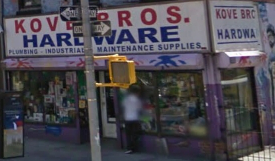

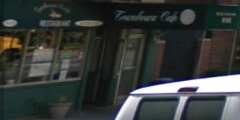

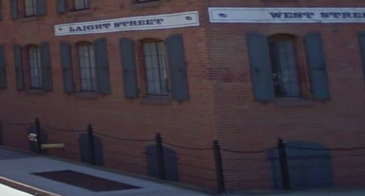

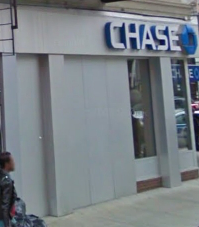

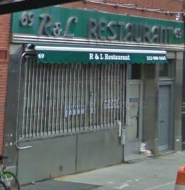

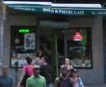

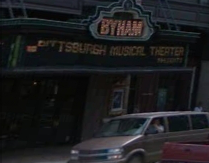

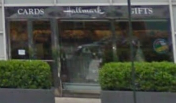

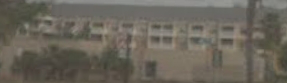

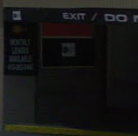

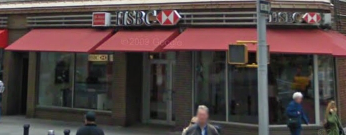

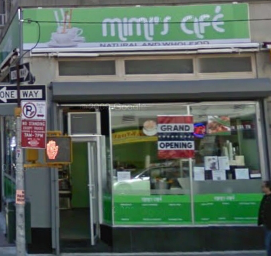

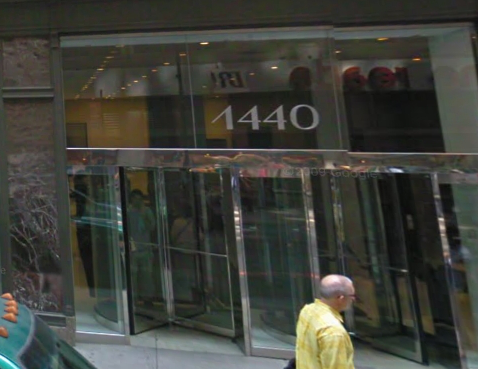

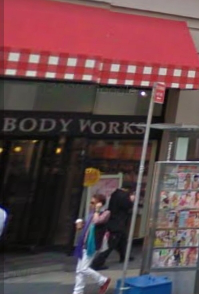

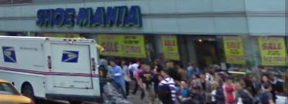

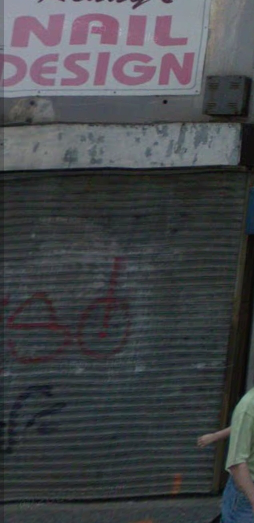

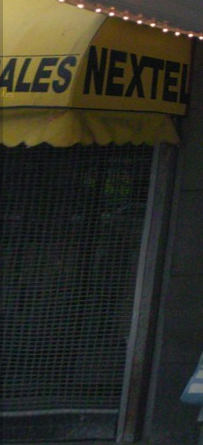

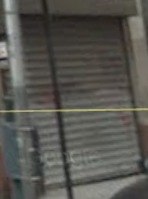

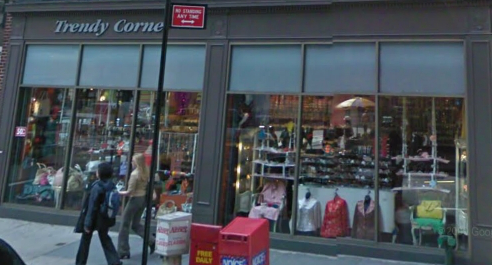

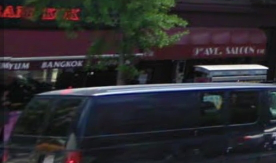

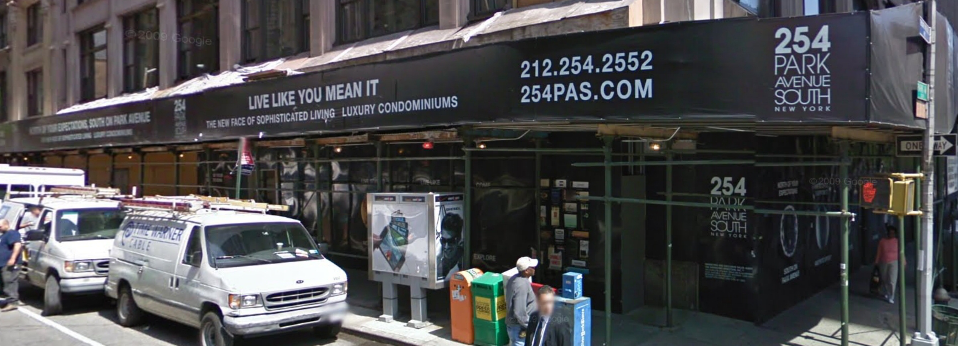

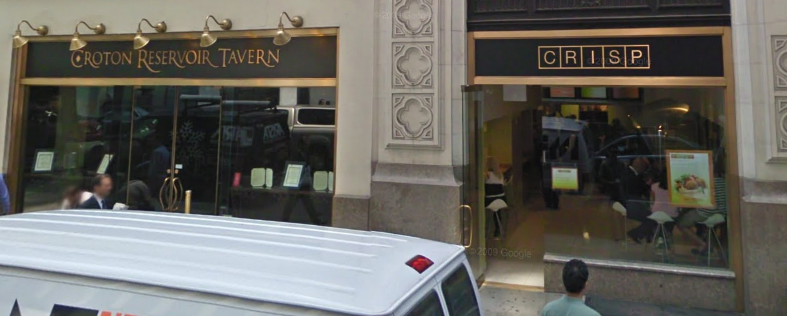

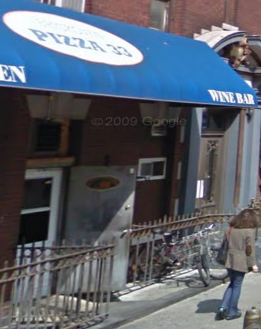

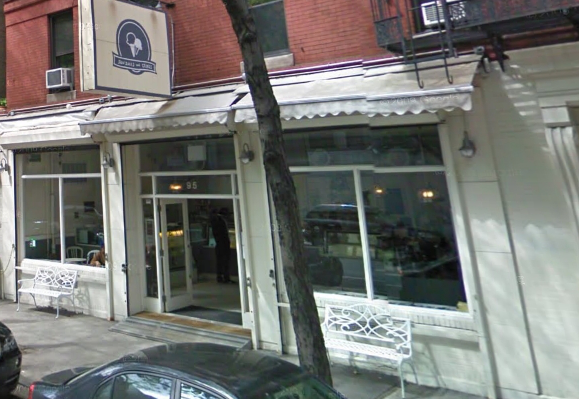

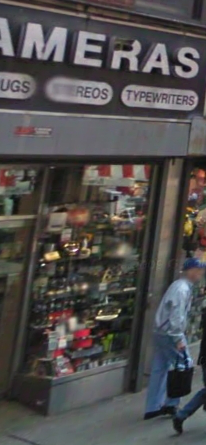

In [20]:
# file_name = "streetlearn_detections_tfexample-00000-of-01000.tfrecord"
# parsed_image_dataset = read_TFRecord(file_name)
# write_TFRecord_UCF(parsed_image_dataset, UCF_img_dir, train_writer)

In [19]:
train_writer.close()
test_writer.close()